# Neural citation network for local citation recommendation

In [1]:
import torch
from torchtext.data import BucketIterator
from ncn.evaluation import Evaluator
from ncn.data import get_datasets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

DEBUG:matplotlib:$HOME=/home/timo
DEBUG:matplotlib:CONFIGDIR=/home/timo/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /home/timo/Programs/miniconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/timo/Programs/miniconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.0
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_

In [17]:
path_to_weights = "/home/timo/Downloads/NCN_7_19_10.pt"
path_to_data = "/home/timo/DataSets/KD_arxiv_CS/arxiv_data.csv"

In [3]:
data = get_datasets(path_to_data)

INFO:neural_citation.data:Getting fields...
INFO:neural_citation.data:Loading dataset...
INFO:neural_citation.data:Building vocab...


In [4]:
def display_dict(d):
    """Display a dict nice and pretty."""
    for key, value in d.items():
        print(f"Citation rank {key}|\t {value}")

In [5]:
def display_attention(title, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap="plasma")
   
    ax.tick_params(labelsize=15)
    xlabels = ["Context TDNN 1 (f=4)", "Context TDNN 2 (f=4)", "Context TDNN 3 (f=5)",
              "Citing TDNN 1 (f=1)", "Citing TDNN 2 (f=2)",
              "Cited TDNN 1 (f=1)", "Cited TDNN 2 (f=2)"
              ]
    ax.set_xticklabels([''] + xlabels, 
                       rotation=90)
    # have tokenized title here
    ax.set_yticklabels([''] + title)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(cax)

## Data: Basic statistics
1. Removed 8260 triplets of paper data due to empty/missing files.  
2. Removed 1 data sample throwing regex error.  
3. Removed 161670 context samples where information was missing/could not be parsed from files.   
* This leaves __502353 context - citation pairs__ with full information.
* __Context vocabulary__ size after processing: __72046__.  
* __Title vocabulary__ size after processing: __43208__.  
* Number of __citing authors__: __28200__.  
* Number of __cited authors__: __169236__. 

![Context and title length distributions](assets/title_context_distribution.jpg)

## Data preprocessing with torchtext Fields  
* __Tokenize and preprocess__ data strings.  
* __Numericalize__ data.  
* Containg __vocabularies__ built on the dataset.  
* Provide __batch processing__ of samples.  

In [6]:
context = "Neural networks are really cool, especially if they are convolutional."
authors = "Chuck Norris, Bruce Lee"

### Tokenization and Preprocessing
* Tokenization
* Stopword removal
* Lowercasing

In [7]:
tokenized = data.cntxt.tokenize(context)

In [8]:
tokenized

['Neural',
 'network',
 'be',
 'really',
 'cool',
 'especially',
 'if',
 'they',
 'be',
 'convolutional']

### Numericalization
* Matching words to vocabulary indices

In [9]:
data.cntxt.numericalize([tokenized])

tensor([[   0,    3,    0,    0, 4615,  772,    0,    0,    0,  411]])

### Batch processing
* Pad batches on the fly

In [10]:
examples = [example.context for example in data.train.examples[:30]]

In [11]:
examples[4]

['recently',
 'concept',
 'energy',
 'share',
 'bss',
 'emerge',
 'step',
 'self',
 'reliance',
 'cellular',
 'network',
 'term',
 'energy']

In [12]:
tensorized = data.cntxt.numericalize(data.cntxt.pad(examples))

In [13]:
print(f"Batch data type: {tensorized.type()}")
print(f"Batch shape: {tensorized.shape}")
print(tensorized[:2, :])

Batch data type: torch.LongTensor
Batch shape: torch.Size([30, 31])
tensor([[  841,     9,    85,  3522,    45,    33,    57,   624,    51,   279,
          1057,     6,   659,  1619,   544,   351,   101,   149,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1],
        [  392,   170,    47, 18682,   751,  2496,   202, 27518,   579,    46,
             0, 14885,   182,    86,   219,  1160,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1]])


## Bucketing: What it is and why do we need it?
* Drastically reduces training time.  
* Ensures all data in a batch is sorted according to certain key (title length in our case).  

In [14]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((data.train, data.valid, data.test), 
                                                                          batch_size = 32,
                                                                          sort_within_batch = True,
                                                                          sort_key = lambda x : len(x.title_cited))

In [15]:
batch = next(iter(train_iterator))

In [16]:
batch.title_cited.permute(1,0)[:5]

tensor([[   2,  144,  175,  486,  444,    3],
        [   2,  415,  369,  481,  176,    3],
        [   2,  570,   76,  220,    6,    3],
        [   2, 3414,   42,   97,   11,    3],
        [   2,  190, 1006, 1114,   17,    3]])

## Demo

In [18]:
evaluator = Evaluator(path_to_weights, data, evaluate=False, show_attention=True)

INFO:neural_citation.evaluation:INITIALIZING NEURAL CITATION NETWORK WITH AUTHORS = True
Running on: cpu
Number of model parameters: 23,844,532
Encoders: # Filters = 128, Context filter length = [4, 4, 5],  Context filter length = [1, 2]
Embeddings: Dimension = 128, Pad index = 1, Context vocab = 30002, Author vocab = 30002, Title vocab = 30004
Decoder: # GRU cells = 2, Hidden size = 128
Parameters: Dropout = 0.2, Show attention = True
-------------------------------------------------
INFO:neural_citation.evaluation:Creating corpus in eval=False mode.
INFO:neural_citation.evaluation:Number of samples in BM25 corpus: 1054941


In [19]:
recomms, a = evaluator.recommend(context, authors)

DEBUG:neural_citation.evaluation:Evaluation title shapes: torch.Size([24, 1028])
DEBUG:neural_citation.ncn:x shape: torch.Size([1028, 384])
DEBUG:neural_citation.ncn:Context encoding shape: torch.Size([3, 1028, 128])
DEBUG:neural_citation.ncn:Forward pass uses author information.
DEBUG:neural_citation.ncn:x shape: torch.Size([1028, 256])
DEBUG:neural_citation.ncn:x shape: torch.Size([1028, 256])
DEBUG:neural_citation.ncn:Citing author encoding shape: torch.Size([2, 1028, 128])
DEBUG:neural_citation.ncn:Cited author encoding shape: torch.Size([2, 1028, 128])
DEBUG:neural_citation.ncn:Attentions viz shape: torch.Size([24, 1028, 7])
DEBUG:neural_citation.ncn:Title shape: torch.Size([1028])
DEBUG:neural_citation.ncn:Hidden shape: torch.Size([1028, 128])
DEBUG:neural_citation.ncn:Encoder output shape: torch.Size([7, 1028, 128])
DEBUG:neural_citation.ncn:Embedded shape: torch.Size([1, 1028, 128])
DEBUG:neural_citation.ncn:Attention Batch size: 1028
DEBUG:neural_citation.ncn:Attention weights

In [20]:
display_dict(recomms)

Citation rank 0|	 Imagenet classification with   deep convolutional neural networks
Citation rank 1|	 Visualizing and understanding convolutional networks
Citation rank 2|	 Very deep convolutional networks for large-scale image   recognition
Citation rank 3|	 Caffe: Convolutional architecture for fast   feature embedding
Citation rank 4|	 Fully convolutional networks for semantic segmentation


## But what about attention?

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f7d9db93630>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f7d9db93630>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


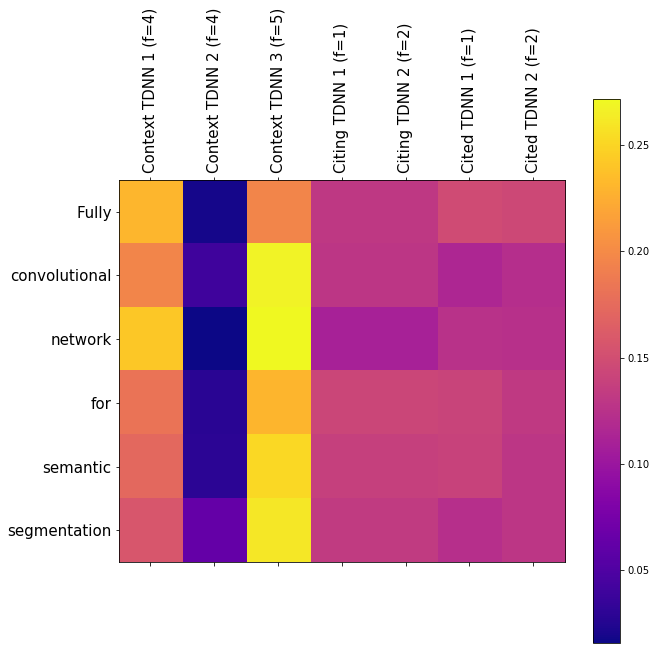

In [26]:
rec = 4
seq = data.cntxt.tokenize(recomms[rec])
display_attention(seq, a[1:len(seq)+1, rec, :])

## Documentation
![Context and title length distributions](assets/Documentation.png)